<a href="https://colab.research.google.com/github/ahmed-boutar/techniques-for-explainability/blob/main/techniques_for_explainability_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

## Description

This notebook implements local and global explanations to the XGBoost model predictions on the sklearn wine dataset using ICE plots, PDP, and ALE Plot. We will first use PCA to decrease multicollinearity in the data as it affects PDPs interpretability. We will then create the plots and interpret them. 

In [ ]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

In [ ]:
!pip install xgboost==1.7.5

In [27]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Dataset Description
The dataset I will be using to train the model is the wine  dataset, provided in the scikit-learn library. The dataset is a popular dataset in machine learning, particularly for multi-classification tasks. In this case, the target feature is whether or not the observation belongs to one of the three target classes (0, 1, or 2)
(Source: https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine)


Authors & License
The Wine dataset is part of scikit-learn, which is distributed under the BSD 3-Clause license, allowing it to be freely used for academic, commercial, and personal projects (provided the original copyright notice and the BSD 3-Clause license text are included)

The dataset was created by Forina, M. et al, PARVUS

Overview
The dataset includes 13 features (all numerical) such as alcohol, color intensity, and hue. These features are properties of the wine instance.

In [37]:
#load the dataset 
wine = load_wine()
df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df['class'] = wine.target
print(df.head())

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  class  
0           

In [29]:
#Data Structure 
print('Data Structure')
print('-'*10)
print(f'Dimensions: {df.shape}')
print(f'Data Types:\n{df.dtypes}')
print(f'Missing Values:\n{df.isnull().sum()}')

Data Structure
----------
Dimensions: (178, 14)
Data Types:
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
class                             int64
dtype: object
Missing Values:
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue       


Variable Relationships in Wine Dataset
---------------
Correlation Matrix


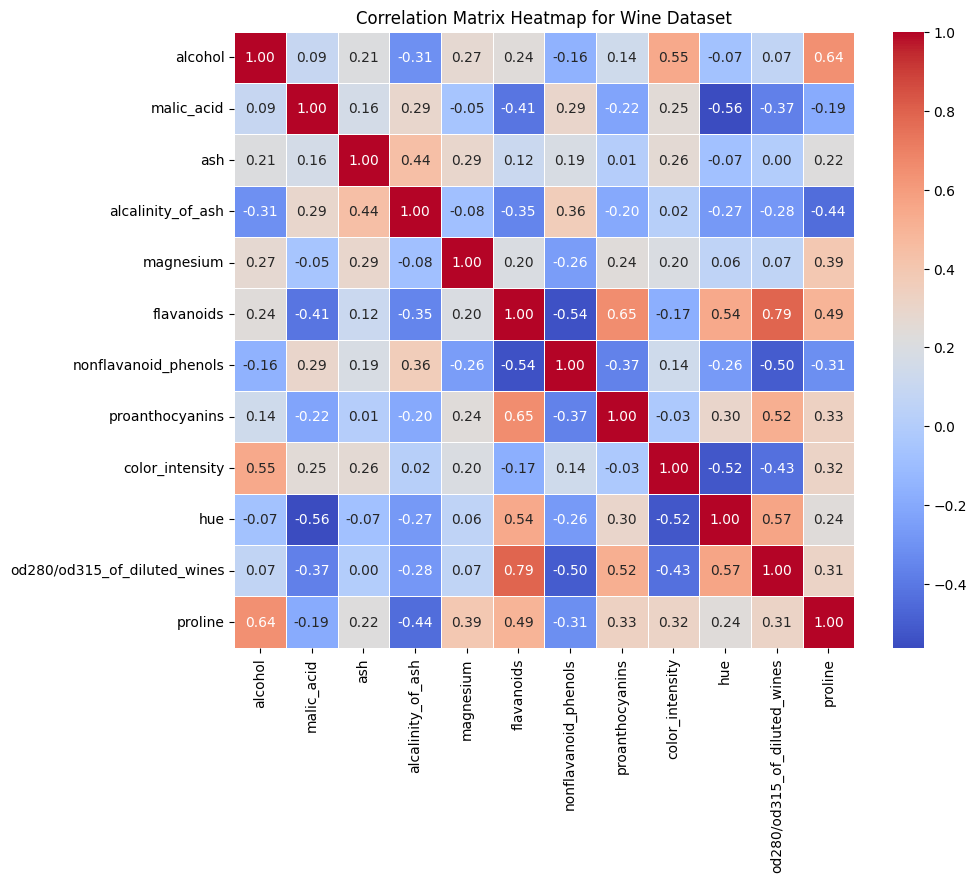

In [32]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_columns = numeric_columns.drop('class')
print(f'\nVariable Relationships in Wine Dataset')
print('-'*15)
print('Correlation Matrix')
correlation_matrix = df[numeric_columns].corr()

#Visualize Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Correlation Matrix Heatmap for Wine Dataset')
plt.show()

As we can see, some of our features are quite correlated. We will try to use PCA to decrease the collinearity since PDPs do not have a clear interpretation when features are correlated

In [121]:
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target


Based on the pair plots above, we will select features that present sepearability between classes and perform PCA on the rest of the features to decrease multicollinearity. 

In [66]:
features_to_keep = ['alcohol', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']  # Example, adjust based on your observations

# Separate features
X_keep = X[features_to_keep]
X_pca = X.drop(columns=features_to_keep)

# Standardize features for PCA
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Apply PCA to the remaining features
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Create a DataFrame with PCA components
X_pca_df = pd.DataFrame(X_pca_transformed, columns=[f'PC{i+1}' for i in range(X_pca_transformed.shape[1])])

# Combine kept features with PCA components
X_final = pd.concat([X_keep, X_pca_df], axis=1)


Variable Relationships in Wine Dataset
---------------
Correlation Matrix


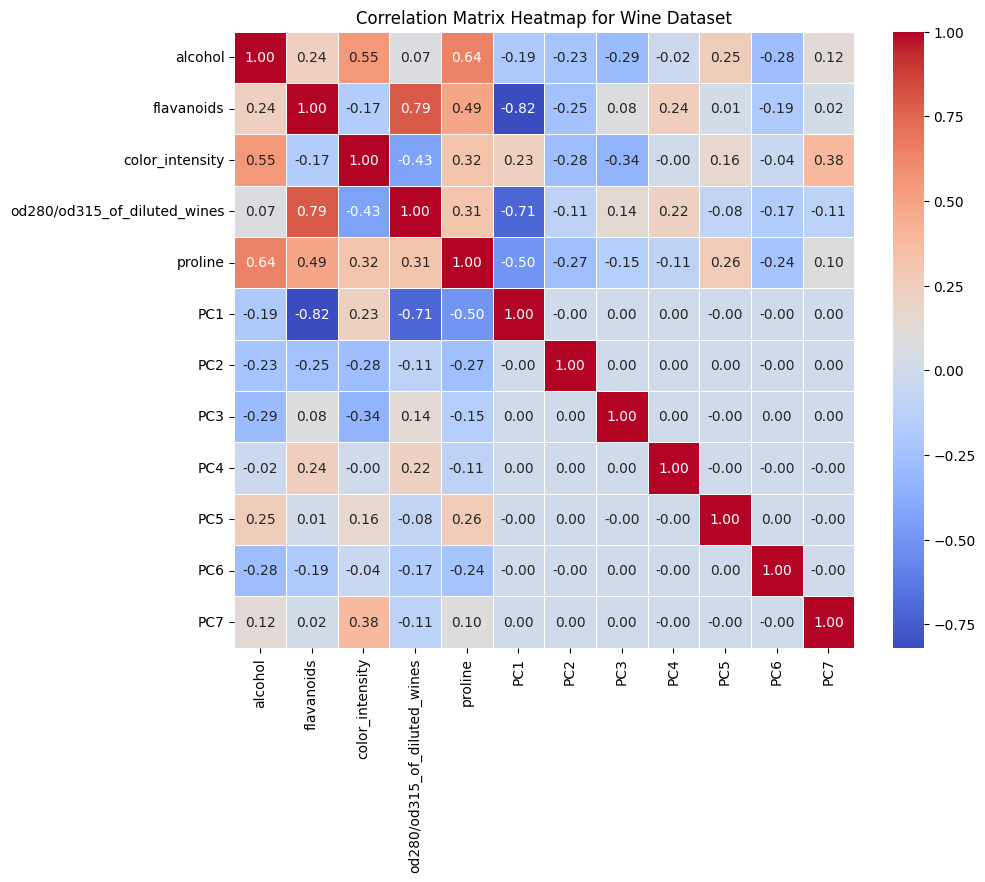

In [67]:
numeric_columns = X_final.select_dtypes(include=[np.number]).columns
print(f'\nVariable Relationships in Wine Dataset')
print('-'*15)
print('Correlation Matrix')
correlation_matrix = X_final[numeric_columns].corr()

#Visualize Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Correlation Matrix Heatmap for Wine Dataset')
plt.show()

We will now apply PCA to flavanoids and od280/od315_of_diluted_wines and PC1 since they are highly correlated

In [68]:
# Separate features

pca_features = ['flavanoids', 'od280/od315_of_diluted_wines', 'PC1']
X_keep = X_final.drop(columns=pca_features)
X_pca = X_final[pca_features]

# Standardize features for PCA
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Apply PCA to the remaining features
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# Create a DataFrame with PCA components
X_pca_df = pd.DataFrame(X_pca_transformed, columns=[f'PC{i+10}' for i in range(X_pca_transformed.shape[1])])

# Combine kept features with PCA components
X_final = pd.concat([X_keep, X_pca_df], axis=1)


Variable Relationships in Wine Dataset
---------------
Correlation Matrix


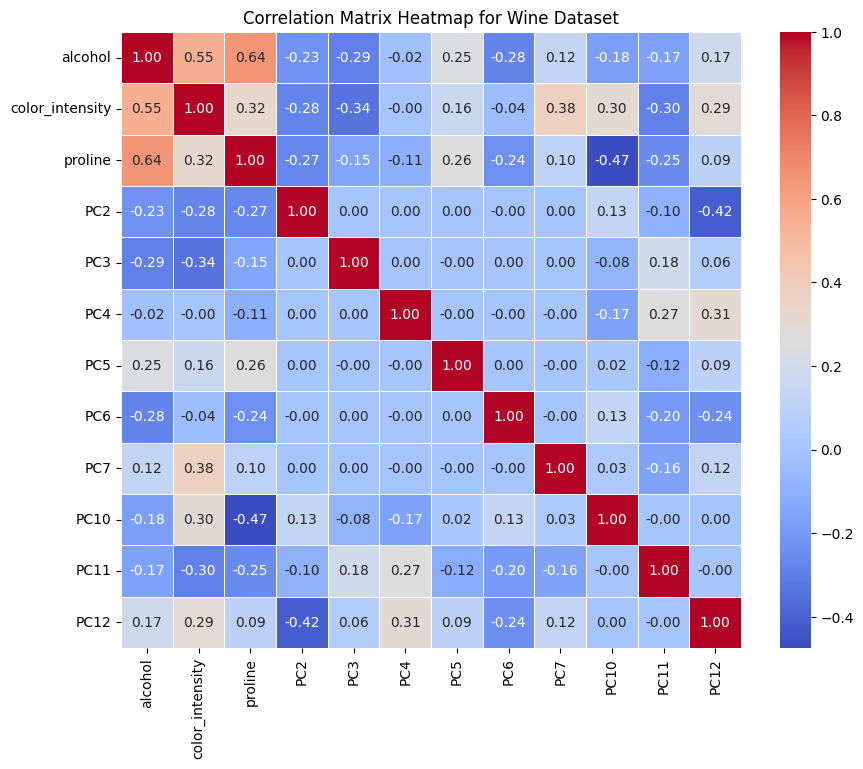

In [69]:

numeric_columns = X_final.select_dtypes(include=[np.number]).columns
print(f'\nVariable Relationships in Wine Dataset')
print('-'*15)
print('Correlation Matrix')
correlation_matrix = X_final[numeric_columns].corr()

#Visualize Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Correlation Matrix Heatmap for Wine Dataset')
plt.show()

Our features do not present multicollinearity now. However, it is important to note that PCA decreases the interpretability

## Modeling

We will use the XGBoost model from the XGBoost library to train it on the dataset. 

In [130]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.5, random_state=42)
model = xgboost.XGBClassifier().fit(X_train, y_train)

In [131]:
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
print(acc)


0.9101123595505618


## PDP 

In [151]:
from sklearn.inspection import PartialDependenceDisplay

We will use the feature 'alcohol' in our PDP plot to understand its effect on the target class. 

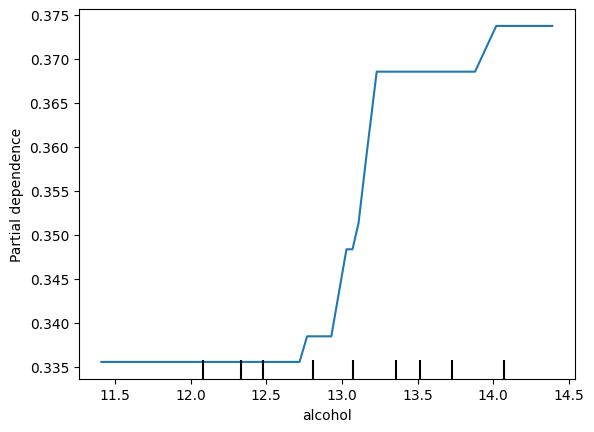

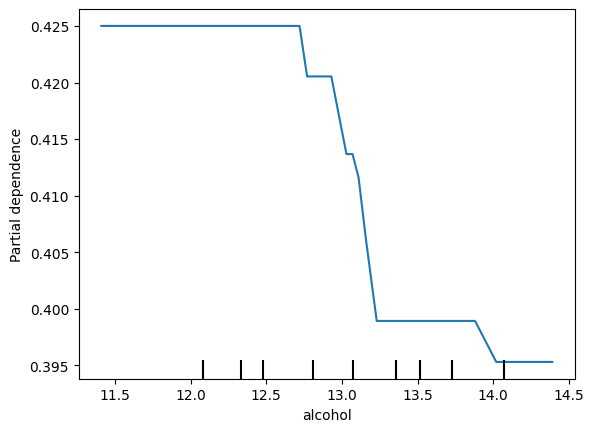

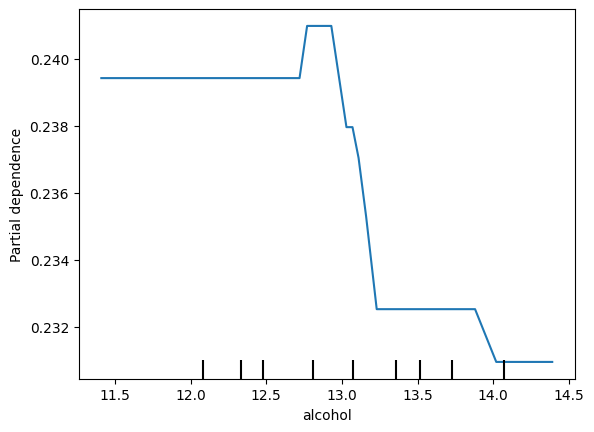

In [154]:
# Choose the feature of interest
features = ["alcohol"]

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average', target=0)
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average', target=1)
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average', target=2)

### Interpretation

The shape of the curve is flat for the lower values of the feature, indicating that changing the feature 'alcohol' has little to no effect on the prediction until it reaches approximately a value of 12.7. Past that value, the change in feature value affects the predictions differently based on the target value. For example, for target 0, the increase in target value increases the probability of predicting the target with an interesting jump around the value 13. 

Across all classes, there is a jump the effect of changing the feature variable on the prediction around 12.7. The effect then decreases for the feature value 13.2 and changes again around 13.8 before stagnating at 14.0. The fact that this behavior is similar across all target classes indicates that the values at which the effect changes can be used to separate the classes. In fact, we were able to confirm this visually using the pair plots where we can see a separation in the target classes for those values. 

It is also important to note that the y-axis range of values is extremely small, suggesting that the alcohol feature may have little impact on the probability of the prediction. 

## ICE Plots

In [187]:
features = ['alcohol']

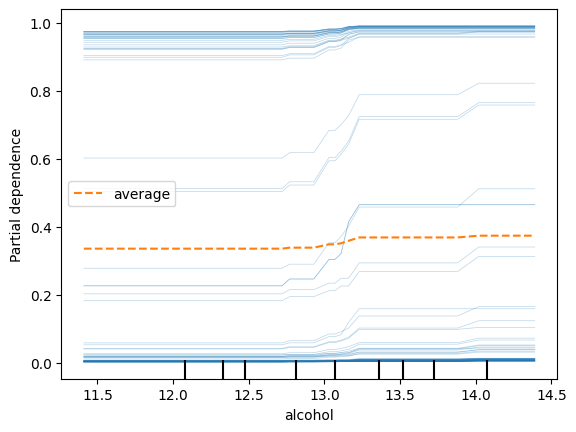

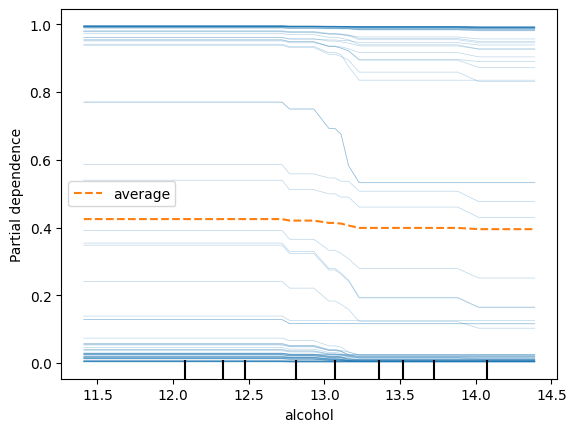

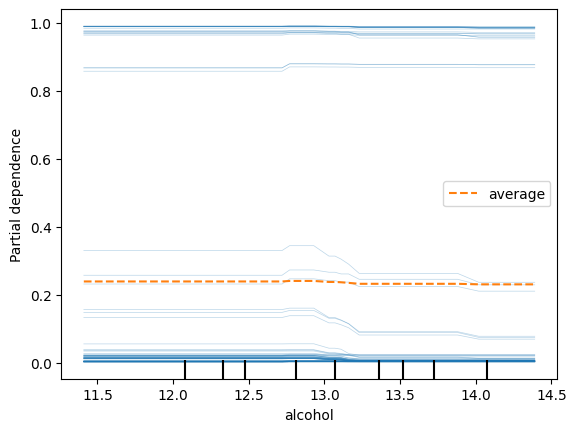

In [190]:
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both', target=0)
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both', target=1)
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both', target=2)

 
The Ice Plots give us insights on the effect of changing the feature variable on the prediction. Most of the curves are relatively flat, indicating little to no effect on the predicted value. Some of the plot lines follow a similar shape to the dependency plots we saw earlier. Overally, by looking at the average of the lines of the ICE plot, we can see that changing the value of alcohol has little to no effect on the predicted value. 

Let's look at the c-ICE Plot

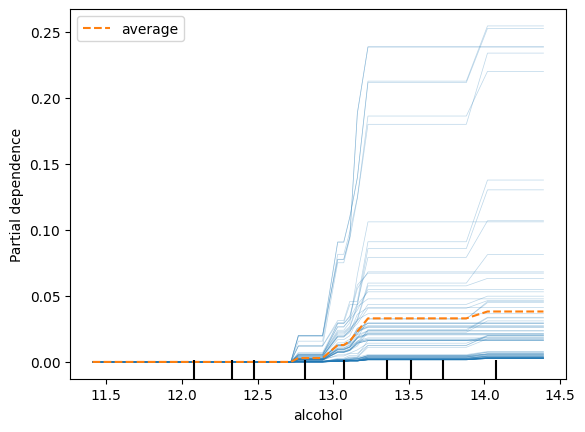

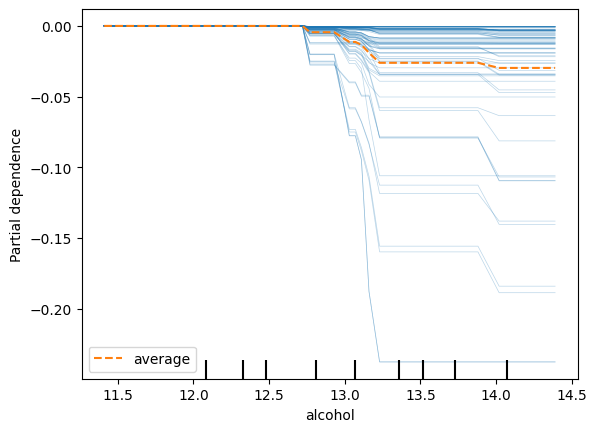

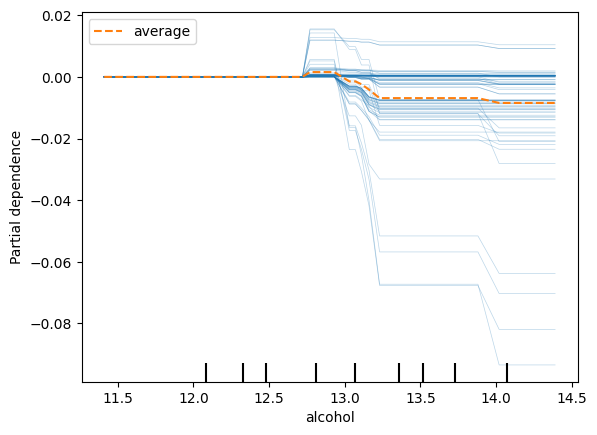

In [191]:
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both', target=0, centered=True)
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both', target=1, centered=True)
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both', target=2, centered=True)

However, once we center our ICE Plot, we can see that there is an effect on the predicted value. While the pdp shows that the effect is very small, some of the ICE plot lines show a very high degree of effect on the predicted value. This suggests that for those observations the alcohol level is much stronger (which might indicate outliers). 

It is interesting to note the ICE Plot for the target class 2 (third plot), we can see that most of the lines follow the general trend (like the pdp). However, for feature value of 12.7 to 13.0, there are higher lines increasing instead of decreasing, suggesting that for those observations, the change in the feature value has an opposite relationship with the target class 2, which could indicate a potential for separation. 

We can also visualize the ICE plot for a single instance and feature

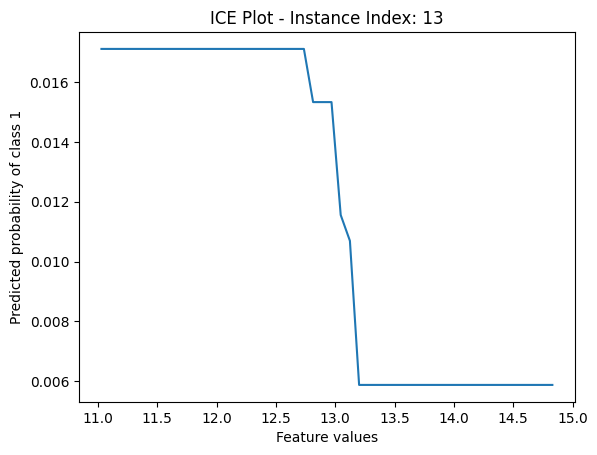

In [193]:
# Choose the instance and feature for which you want to plot the ICE plot
instance_index = 13  # Choose the index of the instance you want to visualize
feature_index = 0  # Let's look at "alcohol"

# Create feature grid
feature_values = np.linspace(np.min(X_final.iloc[:, feature_index]), np.max(X_final.iloc[:, feature_index]), num=50)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Extract the instance of interest
instance = X_final.iloc[[instance_index]]

# Duplicate the instance to modify feature values
instance_modified = instance.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for the instance:
    instance_modified.iloc[:, feature_index] = value
    # Predict using the modified instance:
    prediction = model.predict_proba(instance_modified)[:, 1]

    # Store the prediction for the current feature value:
    average_predictions[i] = prediction.item()

# Plot the ICE plot
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature values')
plt.ylabel('Predicted probability of class 1')
plt.title(f'ICE Plot - Instance Index: {instance_index}')
plt.show()

Based on these plots, we can conclude that there is no linear relationship between the feature alcohol and the predicted probability of the different classes. However, we were able to observe a change in the feature effect for specific values of alcohol, indicating potential separability for the given classes. Although the effect of changing the feature variale is not significant on the predicted probability of y, the sudden changes in the effect shown in the plots is interesting to see as it might suggest separability.

## ALE Plots

In [115]:
from alepython import ale_plot

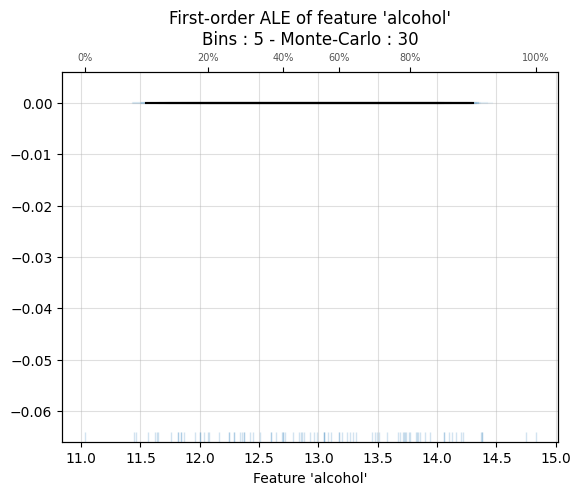

<Axes: title={'center': "First-order ALE of feature 'alcohol'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'alcohol'">

In [144]:
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    model,
    X_train,
    "alcohol",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

However, when we create the ALE plot, we can see that changing the feature value has little to no impact on the predictions since the curve is consistently flat for all feature values. This makes sense in the context of the PDP. Although we saw some effect based on changing the feature value, the effect was minimal. In fact, we can see that from the extremely small range the y-axis. Even though the PDP showed a clear change in effect for specific feature values, the ALE plot did not showcase it. This suggests that the change was small enough to be almost 'unnoticeable' and that this feature may not be as important as we initially thought.

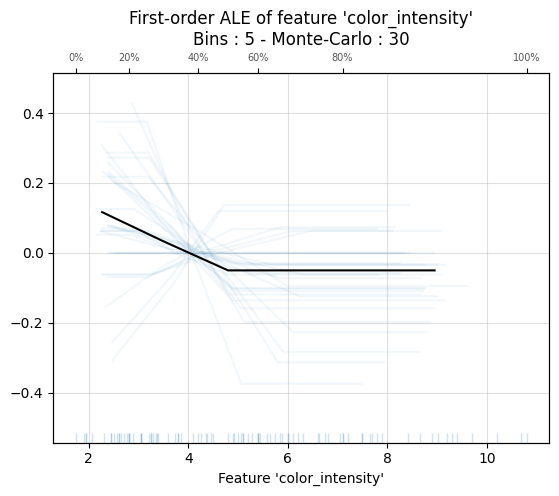

<Axes: title={'center': "First-order ALE of feature 'color_intensity'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'color_intensity'">

In [139]:
# Change hyperparameters for 1D Main Effect ALE Plot
ale_plot(
    model,
    X_train,
    "color_intensity",
    bins=5,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

We can look at the ALE plot of another feature 'color_intensity', which shows monotonic decrease in the average predicted probability as the feature value increases from 2 to 4.7 after which point it flattens. This indicates that beyond the feature value 4.7, the change in feature calue has little to no effect on the predicted probability.